<a href="https://colab.research.google.com/github/VardhanVelamakanni/Mental_stres_Prediction_BandDecomposition_CWT/blob/main/Pipeline4(EEG).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving DASPS+HAM labels.zip to DASPS+HAM labels.zip
Saving Documents and Code.zip to Documents and Code.zip
Saving Raw data mat.zip to Raw data mat.zip


In [2]:
import os, shutil

BASE = "/content/DASPS"
os.makedirs(BASE, exist_ok=True)

for f in uploaded.keys():
    shutil.move(f, BASE+"/"+f)

os.listdir(BASE)


['Raw data mat.zip', 'Documents and Code.zip', 'DASPS+HAM labels.zip']

In [3]:
import zipfile

def unzip(z):
    with zipfile.ZipFile(z,'r') as f:
        f.extractall(BASE)

unzip(BASE+"/Raw data mat.zip")
unzip(BASE+"/DASPS+HAM labels.zip")


In [4]:
!pip install pywavelets scipy matplotlib h5py scikit-learn opencv-python


In [5]:
import numpy as np
import h5py, os, pywt, cv2
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt


In [6]:
def bandpass(sig, low, high, fs=128):
    nyq = 0.5*fs
    b,a = butter(4,[low/nyq,high/nyq],btype='band')
    return filtfilt(b,a,sig,padlen=0)


In [7]:
def get_bands(signal):
    if signal.ndim==2:
        signal=signal[:,0]

    return [
        bandpass(signal,1,4),
        bandpass(signal,4,8),
        bandpass(signal,8,13),
        bandpass(signal,13,30),
        bandpass(signal,30,45)
    ]


In [8]:
def save_multicwt_fusion(bands, path):
    scales = np.arange(1,64)
    imgs=[]

    for b in bands:
        cwt,_ = pywt.cwt(b,scales,'morl')
        img = np.abs(cwt)
        img = (img-img.min())/(img.max()-img.min()+1e-8)
        img = cv2.resize(img,(128,128))
        imgs.append(img)

    R,G,B = imgs[0], imgs[1], imgs[2]
    enhance = (imgs[3]+imgs[4])/2

    fused = np.stack([
        np.clip(R+enhance,0,1),
        np.clip(G+enhance,0,1),
        np.clip(B+enhance,0,1)
    ],axis=-1)

    plt.imsave(path,fused)


In [9]:
def show_band_images(bands):
    scales=np.arange(1,64)
    names=["Delta","Theta","Alpha","Beta","Gamma"]

    plt.figure(figsize=(12,6))
    for i,b in enumerate(bands):
        cwt,_=pywt.cwt(b,scales,'morl')
        plt.subplot(2,3,i+1)
        plt.imshow(np.abs(cwt),cmap='jet',aspect='auto')
        plt.title(names[i])
        plt.axis("off")
    plt.show()


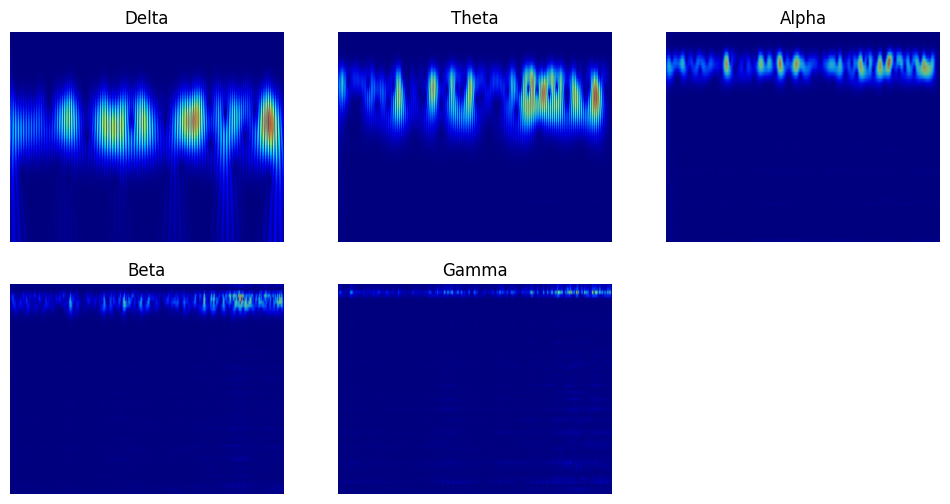

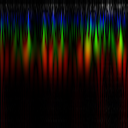

In [10]:
f=h5py.File(BASE+"/Raw data mat/S01.mat",'r')
key=list(f.keys())[0]
eeg=np.array(f[key])

bands=get_bands(eeg[0])
show_band_images(bands)

save_multicwt_fusion(bands,"/content/sample_fused.png")
from IPython.display import Image
Image("/content/sample_fused.png")


In [11]:
FUSED="/content/fused_images"
os.makedirs(FUSED,exist_ok=True)


In [13]:
!pip install tqdm


In [14]:
from tqdm import tqdm
import os, h5py, numpy as np

DATA_PATH = BASE+"/Raw data mat"
count = 0

# count total channels first
total = 0
for file in os.listdir(DATA_PATH):
    f = h5py.File(DATA_PATH+"/"+file,'r')
    key = list(f.keys())[0]
    eeg = np.array(f[key])
    total += eeg.shape[0]

print("Total channels to process:", total)

pbar = tqdm(total=total)

for file in os.listdir(DATA_PATH):
    subject = file.replace(".mat","")
    f = h5py.File(DATA_PATH+"/"+file,'r')
    key = list(f.keys())[0]
    eeg = np.array(f[key])

    for ch in range(eeg.shape[0]):
        bands = get_bands(eeg[ch])
        save_multicwt_fusion(
            bands,
            f"{FUSED}/{subject}_CH{ch}.png"
        )
        count += 1
        pbar.update(1)

pbar.close()
print("Total fused images:", count)


Total channels to process: 276


100%|██████████| 276/276 [00:53<00:00,  5.20it/s]

Total fused images: 276


In [15]:
f=h5py.File(BASE+"/DASPS+HAM labels/DASPS+HAM labels.mat",'r')
labels=np.array(f[list(f.keys())[0]]).squeeze()


In [16]:
def decode_label(l):
    l=l.decode() if isinstance(l,bytes) else str(l)
    return 1 if l[0]=='1' else 0


In [17]:
DATASET="/content/dataset"
for s in ["train","val","test"]:
    for c in ["stress","no_stress"]:
        os.makedirs(f"{DATASET}/{s}/{c}",exist_ok=True)


In [18]:
import glob, shutil

imgs=glob.glob(FUSED+"/*.png")

for img in imgs:
    name=os.path.basename(img)
    sid=name.split("_")[0]
    idx=int(sid.replace("S",""))-1
    lab=decode_label(labels[idx])

    if lab==1:
        shutil.copy(img,f"{DATASET}/train/stress/{name}")
    else:
        shutil.copy(img,f"{DATASET}/train/no_stress/{name}")


In [19]:
from sklearn.model_selection import train_test_split

def split_class(cls):
    p=f"{DATASET}/train/{cls}"
    files=os.listdir(p)
    train,tmp=train_test_split(files,test_size=0.3,random_state=42)
    val,test=train_test_split(tmp,test_size=0.5,random_state=42)

    for f in val:
        shutil.move(p+"/"+f,f"{DATASET}/val/{cls}/{f}")
    for f in test:
        shutil.move(p+"/"+f,f"{DATASET}/test/{cls}/{f}")

split_class("stress")
split_class("no_stress")


In [20]:
for s in ["train","val","test"]:
    for c in ["stress","no_stress"]:
        print(s,c,len(os.listdir(f"{DATASET}/{s}/{c}")))


train stress 75
train no_stress 117
val stress 16
val no_stress 25
test stress 17
test no_stress 26


In [21]:
import shutil

shutil.make_archive(
    "/content/fused_pipeline4_dataset",
    "zip",
    "/content/dataset"
)

print("Dataset zipped successfully!")


Dataset zipped successfully!


In [22]:
from google.colab import files
files.download("/content/fused_pipeline4_dataset.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>